In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from IPython.display import clear_output
%config NotebookApp.iopub_msg_rate_limit=10000
import time
import random
import numpy as np

In [2]:
books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
users = pd.read_csv('users.csv')

C:\Users\zmajernik\AppData\Local\Temp\ipykernel_4076\835546400.py:1: DtypeWarning: Columns (3,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  books = pd.read_csv('books.csv')


In [3]:
books = books[['ISBN', 'Book-Title', 'Book-Author']]
books.head()

,ISBN,Book-Title,Book-Author
0,195153448,Classical Mythology,Mark P. O. Morford
1,2005018,Clara Callan,Richard Bruce Wright
2,60973129,Decision in Normandy,Carlo D'Este
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,393045218,The Mummies of Urumchi,E. J. W. Barber


In [4]:
len(books)

271379

In [5]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [6]:
def findModes(lst, n):
    counter = Counter(lst)
    modes = counter.most_common(n)
    return [mode[0] for mode in modes]

In [7]:
numTopBooks = 6
booksToCluster = findModes(ratings['ISBN'], numTopBooks)
possibleUsers = []

for i in range(0,1000):
    booksRated = ratings.loc[ratings.loc[:,'User-ID'] == i].reset_index(drop=True).values
    topBooksRated = np.sum(np.isin(booksRated, booksToCluster))
    if topBooksRated >= 2:
        possibleUsers.append(i)

In [8]:
possibleUsers

[243, 638, 805, 882]

In [9]:
def randIdx(lstLength):
    idx = random.randint(0,lstLength-1)
    return idx

In [10]:
print(booksToCluster)
filteredRatings = ratings[ratings['ISBN'].isin(booksToCluster)].copy().reset_index(drop=True)
filteredRatings.head()

['971880107', '316666343', '385504209', '60928336', '312195516', '044023722X']


,User-ID,ISBN,Book-Rating
0,276925,316666343,0
1,276925,385504209,8
2,276925,971880107,0
3,276939,971880107,0
4,276954,971880107,0


In [11]:
filteredRatings = filteredRatings.drop_duplicates()
filteredRatings = filteredRatings.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating', aggfunc='mean')
filteredRatings.fillna(0, inplace=True)

In [12]:
filteredRatings.head()

ISBN,044023722X,312195516,316666343,385504209,60928336,971880107
User-ID,,,,,,
14,0.0,0.0,0.0,0.0,0.0,0.0
193,0.0,0.0,0.0,0.0,0.0,0.0
242,0.0,0.0,0.0,0.0,0.0,0.0
243,7.0,0.0,0.0,0.0,0.0,0.0
256,8.0,0.0,0.0,0.0,0.0,0.0


In [13]:
len(filteredRatings)

5418

In [14]:
scores = {}
clusters = 250
for i in range(2, clusters):
    agg = AgglomerativeClustering(n_clusters=i, affinity='euclidean', linkage='ward')
    agg = agg.fit(filteredRatings)
    ss_avg = silhouette_score(filteredRatings, agg.labels_)
    scores[i] = ss_avg
    percentDone = round(((i-1)/(clusters-2))*100,2)
    clear_output(wait=True)
    time.sleep(0.001)
    print(str(percentDone) + "% done")

100.0% done


156


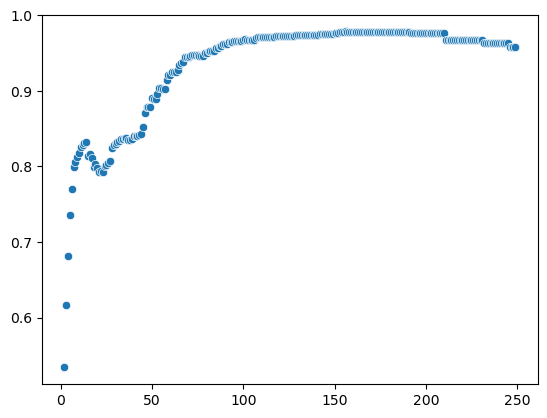

In [15]:
sns.scatterplot(x=scores.keys(), y=scores.values())
bestClusters = max(scores, key=scores.get)
print(bestClusters)

In [16]:
scores[bestClusters]

0.9785616392239811

In [17]:
agg = AgglomerativeClustering(n_clusters=50, affinity='euclidean', linkage='ward')
agg = agg.fit(filteredRatings)

In [18]:
filteredRatings["cluster"] = agg.labels_
filteredRatings.reset_index(inplace=True)
filteredRatings.head()

ISBN,User-ID,044023722X,312195516,316666343,385504209,60928336,971880107,cluster
0,14,0.0,0.0,0.0,0.0,0.0,0.0,22
1,193,0.0,0.0,0.0,0.0,0.0,0.0,22
2,242,0.0,0.0,0.0,0.0,0.0,0.0,22
3,243,7.0,0.0,0.0,0.0,0.0,0.0,8
4,256,8.0,0.0,0.0,0.0,0.0,0.0,8


In [19]:
filteredRatings.loc[filteredRatings.loc[:,'User-ID'] == 805]

ISBN,User-ID,044023722X,312195516,316666343,385504209,60928336,971880107,cluster
12,805,0.0,0.0,0.0,0.0,7.0,0.0,19


In [20]:
filteredRatings.loc[filteredRatings.loc[:,'cluster'] == 19]

ISBN,User-ID,044023722X,312195516,316666343,385504209,60928336,971880107,cluster
12,805,0.0,0.0,0.0,0.0,7.0,0.0,19
42,2559,0.0,0.0,0.0,0.0,7.0,0.0,19
83,5439,0.0,0.0,0.0,0.0,8.0,0.0,19
104,6349,0.0,0.0,0.0,0.0,8.0,0.0,19
118,7107,0.0,0.0,0.0,0.0,8.0,0.0,19
...,...,...,...,...,...,...,...,...
5261,269759,0.0,0.0,0.0,0.0,7.0,0.0,19
5334,274017,0.0,0.0,0.0,0.0,8.0,0.0,19
5345,274380,0.0,0.0,0.0,0.0,8.0,0.0,19
5361,275357,0.0,0.0,0.0,0.0,8.0,0.0,19


In [21]:
clusterUsers = filteredRatings.loc[filteredRatings.loc[:,'cluster'] == 19]['User-ID'].unique()
filteredRatings = ratings.loc[ratings['User-ID'].isin(clusterUsers)].reset_index(drop=True)
moviesSeen = filteredRatings.loc[filteredRatings.loc[:,'User-ID'] == 805]['ISBN'].unique()
filteredRatings = filteredRatings[~filteredRatings['ISBN'].isin(moviesSeen)].reset_index(drop=True)
filteredRatings = filteredRatings.pivot(index='User-ID', columns='ISBN', values='Book-Rating')
filteredRatings.head()

ISBN,000716131X,002037500X,002542730X,006000438X,006001203X,0060096510X,006018311X,006019393X,006019538X,006019877X,...,974205494,9901500222,99255723,99272822,99422042,99433311,99436744,99473216,99760118,99769913
User-ID,,,,,,,,,,,,,,,,,,,,,
2559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5439,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
item_means = pd.DataFrame(filteredRatings.mean(axis=0))
item_means

,0
ISBN,
000716131X,0.0
002037500X,7.0
002542730X,0.0
006000438X,0.0
006001203X,5.0
...,...
99433311,6.0
99436744,0.0
99473216,0.0


In [25]:
item_means.idxmax()

0    014015020X
dtype: object

In [26]:
books.loc[books.loc[:,'ISBN'] == '014015020X']

,ISBN,Book-Title,Book-Author
48616,014015020X,Portable Mark Twain (The Viking Portable Library),Mark Twain


In [28]:
item_means.loc['014015020X']

0    10.0
Name: 014015020X, dtype: float64